<a href="https://colab.research.google.com/github/asheta66/CNN/blob/main/Breast_Diagnosis_Model_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip uninstall -y pandas tensorflow
# !pip install pandas tensorflow
# !pip install seaborn


In [ ]:
# Install latex
# !sudo apt-get update -y
# !sudo apt-get install -y texlive texlive-latex-extra texlive-fonts-recommended dvipng cm-super

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import plot_model
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define your data directory path and resolution options
data_dir = '/content/drive/My Drive/data2'
resolution_options = {
    '32x32': (32, 32),
    '56x56': (56, 56),
    '128x128': (128, 128),
    '256x256': (256, 256),
    '512x512': (512, 512)
}

# Select a resolution
print("\nSelect the resolution:")
for i, (res_name, res_size) in enumerate(resolution_options.items(), 1):
    print(f"{i}. {res_name}")
print("")
selection_index = int(input("Enter the number corresponding to your choice: ")) - 1

print(f"selection_index",selection_index)

# Validate the selection
if selection_index < 0 or selection_index >= len(resolution_options):
    raise ValueError("Invalid selection. Exiting.")

# Set the selected resolution and data directory
selected_resolution_name = list(resolution_options.keys())[selection_index]
selected_resolution_size = resolution_options[selected_resolution_name]
data_dir = os.path.join(data_dir, selected_resolution_name)

# Check if the data directory exists
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"Directory '{data_dir}' does not exist.")

# Get class names (subfolders)
classes = [cls for cls in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, cls))]

# Display number of images per class
for cls in classes:
    num_images = len(os.listdir(os.path.join(data_dir, cls)))
    print(f"Class '{cls}': {num_images} images")

# Build and compile the CNN model
def build_compile_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Load a single image
def load_image(directory, cls, img_file):
    img_path = os.path.join(directory, cls, img_file)
    img = Image.open(img_path)
    return img

# Prepare data
X, y = [], []
label_map = {cls: idx for idx, cls in enumerate(classes)}

for cls in classes:
    cls_dir = os.path.join(data_dir, cls)
    for img_file in os.listdir(cls_dir):
        img_path = os.path.join(cls_dir, img_file)
        img = load_img(img_path, target_size=selected_resolution_size)
        img_array = img_to_array(img)
        X.append(img_array)
        y.append(label_map[cls])

X = np.array(X).astype('float32') / 255.0
y = np.array(y).astype('int')

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=22)

# Build and compile model
input_shape = (selected_resolution_size[0], selected_resolution_size[1], 3)
num_classes = len(classes)
model = build_compile_model(input_shape, num_classes)

# Train the model
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

# Initialize a list to store metrics for saving
metrics = []

# Predict and evaluate
train_predictions = np.argmax(model.predict(X_train), axis=1)
test_predictions = np.argmax(model.predict(X_test), axis=1)

# Compute metrics for training data
train_accuracy = accuracy_score(y_train, train_predictions)
train_precision = precision_score(y_train, train_predictions, average='weighted')
train_recall = recall_score(y_train, train_predictions, average='weighted')
train_f1 = f1_score(y_train, train_predictions, average='weighted')

# Store training metrics in the list
metrics.append({
    'Dataset': 'Training',
    'Resolution': f'{selected_resolution_size[0]}x{selected_resolution_size[1]}',
    'Accuracy': train_accuracy,
    'Precision': train_precision,
    'Recall': train_recall,
    'F1 Score': train_f1
})

# Compute metrics for testing data
test_accuracy = accuracy_score(y_test, test_predictions)
test_precision = precision_score(y_test, test_predictions, average='weighted')
test_recall = recall_score(y_test, test_predictions, average='weighted')
test_f1 = f1_score(y_test, test_predictions, average='weighted')

# Store testing metrics in the list
metrics.append({
    'Dataset': 'Testing',
    'Resolution': f'{selected_resolution_size[0]}x{selected_resolution_size[1]}',
    'Accuracy': test_accuracy,
    'Precision': test_precision,
    'Recall': test_recall,
    'F1 Score': test_f1
})

# Create a DataFrame from the metrics list
metrics_df = pd.DataFrame(metrics)

# Display metrics DataFrame
print(metrics_df)

# Define filename with resolution
excel_filename = f'performance_metrics_{selected_resolution_size[0]}x{selected_resolution_size[1]}.xlsx'

# Save the DataFrame to an Excel file
metrics_df.to_excel(excel_filename, index=False, sheet_name='Performance Metrics')

print(f"Metrics saved to {excel_filename}")

# Save the CNN architecture as a PNG figure
plot_model(model, to_file=f'model_architecture_{selected_resolution_size[0]}x{selected_resolution_size[1]}.png', show_shapes=True, show_layer_names=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Select the resolution:
1. 32x32
2. 56x56
3. 128x128
4. 256x256
5. 512x512

Class 'malignant': 360 images
Class 'benign': 537 images
Class 'normal': 133 images


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.4605 - loss: 1.2094 - val_accuracy: 0.5194 - val_loss: 1.0030
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - accuracy: 0.5968 - loss: 0.8965 - val_accuracy: 0.6408 - val_loss: 0.8242
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.6510 - loss: 0.7559 - val_accuracy: 0.6845 - val_loss: 0.6695
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.7857 - loss: 0.5293 - val_accuracy: 0.7136 - val_loss: 0.6653
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.8575 - loss: 0.3867 - val_accuracy: 0.7816 - val_loss: 0.6296
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.9158 - loss: 0.2327 - val_accuracy: 0.7767 - val_loss: 0.5736
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.9628 - loss: 0.1316 - val_accuracy: 0.7718 - val_loss: 0.6491
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.9727 - loss: 0.0993 - val_accuracy: 0.7961 - val_loss:

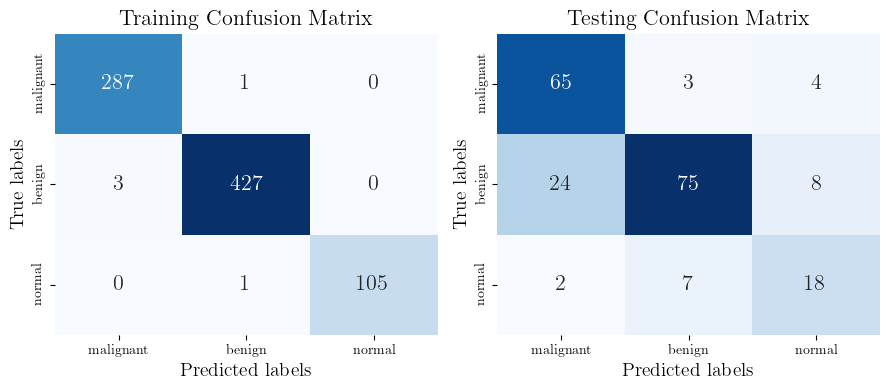

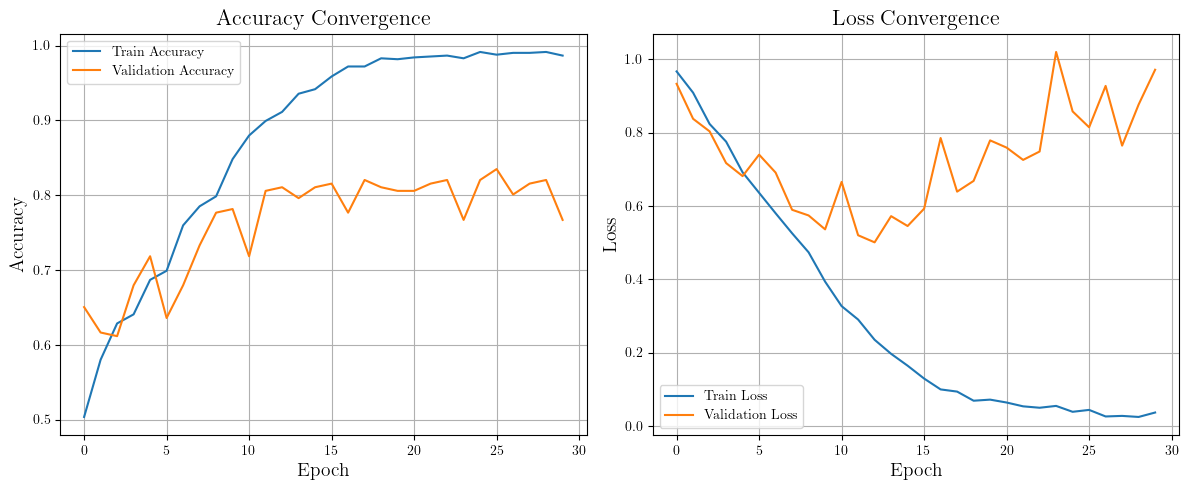

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrices
def plot_confusion_matrices(cm_train, cm_test, class_names, filename='confusion_matrices.png'):
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"],
    })
    fig, axes = plt.subplots(1, 2, figsize=(9, 4))
    sns.heatmap(cm_train, annot=True, fmt='d', ax=axes[0], cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=False, annot_kws={"size": 16})
    axes[0].set_title('Training Confusion Matrix', fontsize=16)
    axes[0].set_xlabel('Predicted labels', fontsize=14)
    axes[0].set_ylabel('True labels', fontsize=14)
    sns.heatmap(cm_test, annot=True, fmt='d', ax=axes[1], cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=False, annot_kws={"size": 16})
    axes[1].set_title('Testing Confusion Matrix', fontsize=16)
    axes[1].set_xlabel('Predicted labels', fontsize=14)
    axes[1].set_ylabel('True labels', fontsize=14)
    plt.tight_layout()
    plt.savefig(filename, bbox_inches='tight')
    plt.show()
    plt.close()

# Assuming `cm_train` and `cm_test` are already computed
cm_train = confusion_matrix(y_train, train_predictions)
cm_test = confusion_matrix(y_test, test_predictions)
plot_confusion_matrices(cm_train, cm_test, classes, filename=f'confusion_matrices_{selected_resolution_size[0]}x{selected_resolution_size[1]}.png')

# Plot convergence curves
def plot_convergence_curves(history, filename='convergence_curves.png'):
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"],
    })
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Accuracy Convergence', fontsize=16)
    ax1.set_xlabel('Epoch', fontsize=14)
    ax1.set_ylabel('Accuracy', fontsize=14)
    ax1.legend()
    ax1.grid()
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Loss Convergence', fontsize=16)
    ax2.set_xlabel('Epoch', fontsize=14)
    ax2.set_ylabel('Loss', fontsize=14)
    ax2.legend()
    ax2.grid()
    plt.tight_layout()
    plt.savefig(filename, bbox_inches='tight')
    plt.show()
    plt.close()

# Assuming `history` is already computed
plot_convergence_curves(history, filename=f'convergence_curves_{selected_resolution_size[0]}x{selected_resolution_size[1]}.png')
